# TradeAxis Showcase

This notebook demonstrates the core features of `tradeaxis`:

1. **Gap compression** -- automatic detection and removal of overnight/weekend gaps
2. **LOD decimation** -- millions of points rendered efficiently with min/max preservation
3. **Trader-style interaction** -- pan, zoom, crosshair (interactive backends only)
4. **matplotlib compatibility** -- everything you know still works

> **Tip:** For interactive features (pan/zoom/crosshair), use `%matplotlib qt` (cross-platform, requires PyQt6 -- included in dev deps), `%matplotlib macosx` (macOS native), or `%matplotlib tk` (requires tkinter).
> The default `inline` backend renders static images only -- good enough for seeing the visual output.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import tradeaxis as ta

# Utility: generate 1-min timestamps for a single US equity trading session
def make_trading_day(date_str, freq_min=1):
    """Return 1-min timestamps for 09:30 - 16:00."""
    base = np.datetime64(date_str)
    start = base + np.timedelta64(9 * 60 + 30, "m")
    end = base + np.timedelta64(16 * 60, "m")
    return np.arange(start, end, np.timedelta64(freq_min, "m"))

print(f"tradeaxis loaded: {ta.__all__}")

tradeaxis loaded: ['Chart', 'wrap', 'plot_intraday']


## 1. The Problem: Ugly Gaps in Raw Datetime Plots

Plotting intraday data with matplotlib's default datetime x-axis produces a huge empty
gap between the 16:00 close and the next day's 09:30 open. The chart is mostly whitespace.

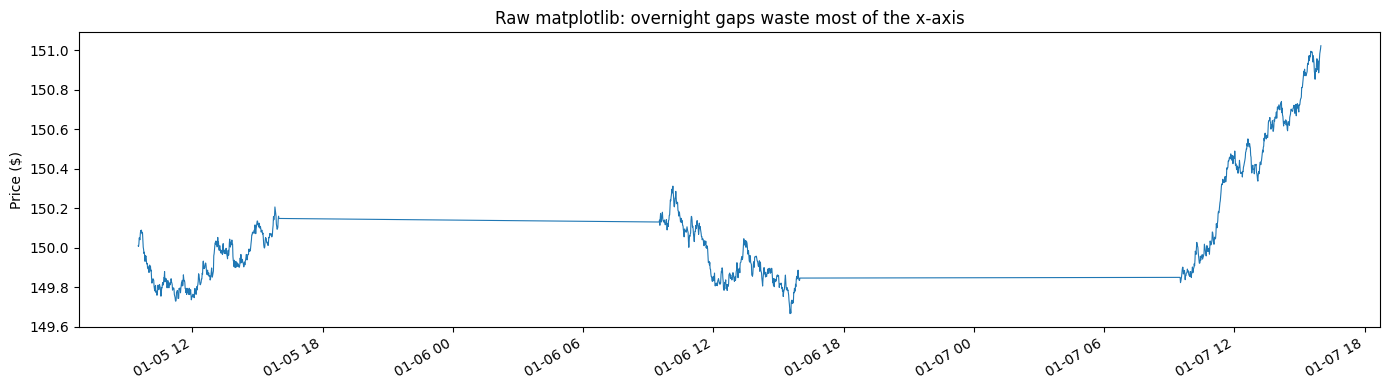

In [2]:
# Build 3 days of 1-min equity data
np.random.seed(42)
timestamps = np.concatenate([
    make_trading_day("2026-01-05"),  # Monday
    make_trading_day("2026-01-06"),  # Tuesday
    make_trading_day("2026-01-07"),  # Wednesday
])
prices = 150 + np.cumsum(np.random.randn(len(timestamps)) * 0.02)

# --- Raw matplotlib (the problem) ---
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(timestamps, prices, linewidth=0.8)
ax.set_title("Raw matplotlib: overnight gaps waste most of the x-axis")
ax.set_ylabel("Price ($)")
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## 2. The Fix: `ta.wrap()` Compresses Gaps Automatically

One line turns the same axes into a gap-compressed trading chart. Dashed separators mark session boundaries.
Tick labels still show real timestamps.

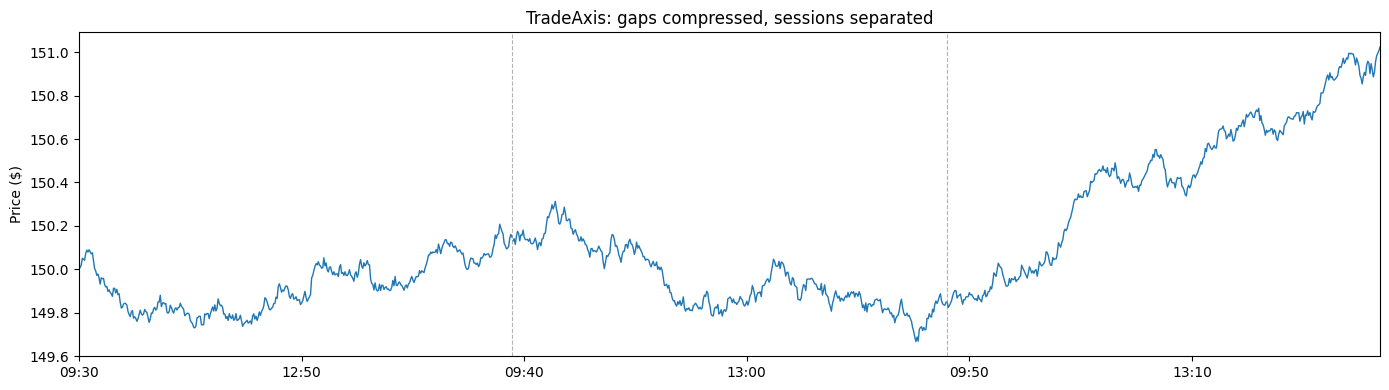

Data points: 1,170
Gaps detected: 2
Line segments: 3


In [3]:
# --- TradeAxis: gap compression ---
fig, ax = plt.subplots(figsize=(14, 4))
chart = ta.wrap(ax, timestamps, prices, interaction=False)

ax.set_title("TradeAxis: gaps compressed, sessions separated")
ax.set_ylabel("Price ($)")
plt.tight_layout()
plt.show()

print(f"Data points: {len(timestamps):,}")
print(f"Gaps detected: {chart.mapping.gap_mask.sum()}")
print(f"Line segments: {len(chart._data_lines)}")

## 3. Full matplotlib Compatibility

The `ax` returned is still a standard matplotlib `Axes`. All the methods you know work exactly as before.

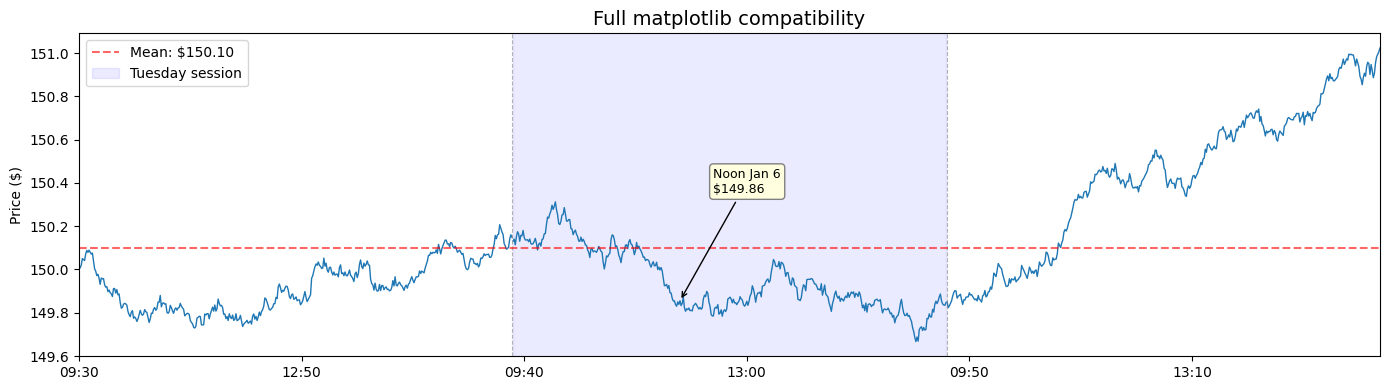

In [4]:
fig, ax = plt.subplots(figsize=(14, 4))
chart = ta.wrap(ax, timestamps, prices, interaction=False)

# Standard matplotlib calls -- all work unchanged
ax.set_title("Full matplotlib compatibility", fontsize=14)
ax.set_ylabel("Price ($)")

# Horizontal line at mean price
mean_price = prices.mean()
ax.axhline(mean_price, color="red", ls="--", alpha=0.6, label=f"Mean: ${mean_price:.2f}")

# Annotate a specific point using chart.to_index()
target_time = np.datetime64("2026-01-06T12:00")
idx = chart.to_index(target_time)
ax.annotate(
    f"Noon Jan 6\n${prices[idx]:.2f}",
    xy=(idx, prices[idx]),
    xytext=(idx + 30, prices[idx] + 0.5),
    arrowprops=dict(arrowstyle="->", color="black"),
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="gray"),
)

# Vertical highlight span (using index space)
day2_start = chart.to_index(np.datetime64("2026-01-06T09:30"))
day2_end = chart.to_index(np.datetime64("2026-01-06T16:00") - np.timedelta64(1, "m"))
ax.axvspan(day2_start, day2_end, alpha=0.08, color="blue", label="Tuesday session")

ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

## 4. LOD Decimation: Handling Large Datasets

TradeAxis uses min/max bucket downsampling so even millions of points render instantly.
When you zoom in (interactively or programmatically), the visible data is refined to full resolution.
Spikes and extrema are always preserved.

Total data points: 7,800


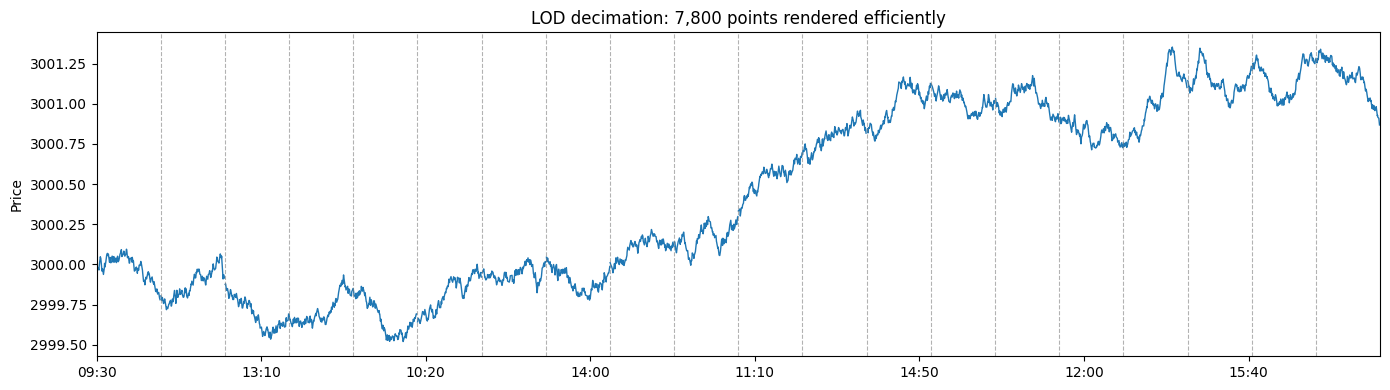

Rendered points: 1,950 (out of 7,800)
Compression ratio: 4x
Time to create chart: 0.025s


In [5]:
import time

# Generate a large dataset: 20 trading days at 1-second resolution
big_timestamps = np.concatenate([
    make_trading_day(f"2026-01-{d:02d}", freq_min=1) for d in range(5, 25)
])
np.random.seed(123)
big_prices = 3000 + np.cumsum(np.random.randn(len(big_timestamps)) * 0.01)

print(f"Total data points: {len(big_timestamps):,}")

# Time the wrap call
t0 = time.perf_counter()
fig, ax = plt.subplots(figsize=(14, 4))
chart = ta.wrap(ax, big_timestamps, big_prices, interaction=False)
ax.set_title(f"LOD decimation: {len(big_timestamps):,} points rendered efficiently")
ax.set_ylabel("Price")
plt.tight_layout()
elapsed = time.perf_counter() - t0
plt.show()

# How many points are actually drawn?
rendered = sum(len(line.get_xdata()) for line in chart._data_lines)
print(f"Rendered points: {rendered:,} (out of {len(big_timestamps):,})")
print(f"Compression ratio: {len(big_timestamps) / max(rendered, 1):.0f}x")
print(f"Time to create chart: {elapsed:.3f}s")

## 5. Custom Gap Thresholds

The `gap` parameter controls how gaps are detected:
- `"auto"` (default) -- uses `20 * median(dt)` heuristic
- `timedelta(...)` -- explicit threshold
- `callable` -- full control, receives timestamps and returns a boolean mask

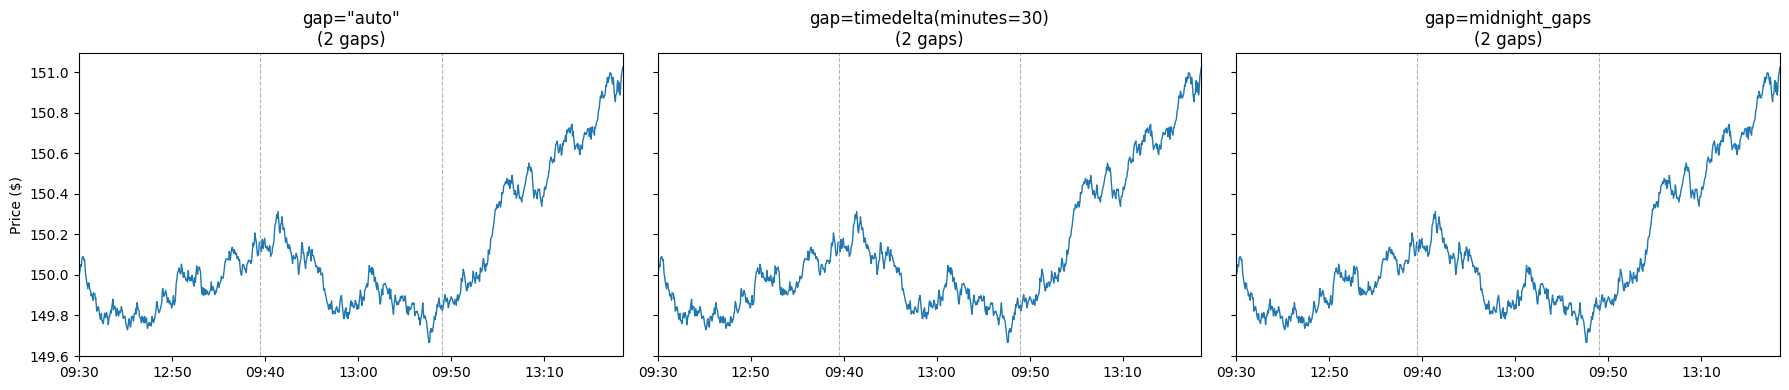

In [6]:
from datetime import timedelta

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

# Auto detection
chart1 = ta.wrap(axes[0], timestamps, prices, gap="auto", interaction=False)
axes[0].set_title(f'gap="auto"\n({chart1.mapping.gap_mask.sum()} gaps)')
axes[0].set_ylabel("Price ($)")

# Explicit 30-minute threshold (detects even lunch breaks if present)
chart2 = ta.wrap(axes[1], timestamps, prices, gap=timedelta(minutes=30), interaction=False)
axes[1].set_title(f'gap=timedelta(minutes=30)\n({chart2.mapping.gap_mask.sum()} gaps)')

# Custom callable: only break at midnight crossings
def midnight_gaps(ts):
    """Flag gaps where the date changes."""
    dates = ts.astype("datetime64[D]")
    mask = np.zeros(len(ts), dtype=bool)
    mask[1:] = dates[1:] != dates[:-1]
    return mask

chart3 = ta.wrap(axes[2], timestamps, prices, gap=midnight_gaps, interaction=False)
axes[2].set_title(f'gap=midnight_gaps\n({chart3.mapping.gap_mask.sum()} gaps)')

plt.tight_layout()
plt.show()

## 6. Disabling Features Selectively

Every feature is opt-in. You can use gap compression without separators, or without interaction.

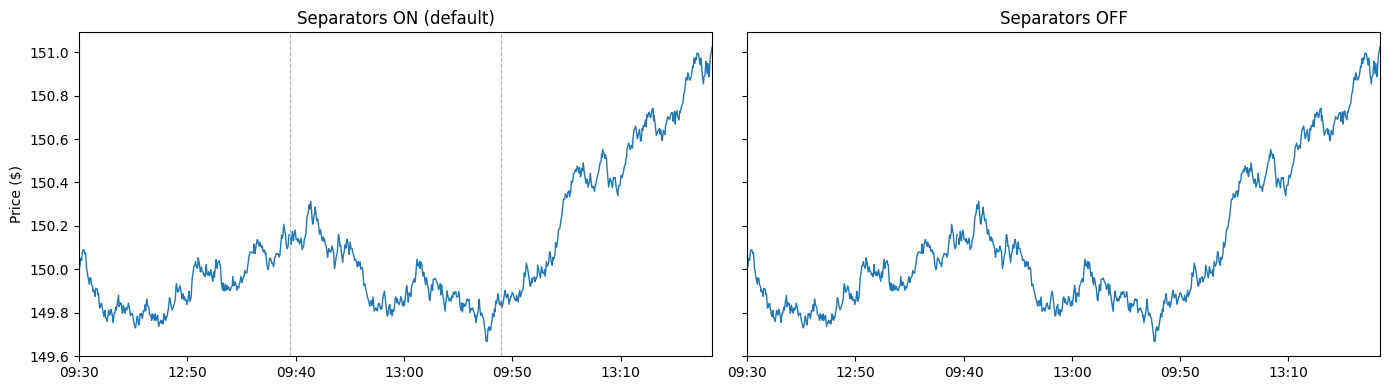

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# With separators (default)
ta.wrap(axes[0], timestamps, prices, show_separators=True, interaction=False)
axes[0].set_title("Separators ON (default)")
axes[0].set_ylabel("Price ($)")

# Without separators
ta.wrap(axes[1], timestamps, prices, show_separators=False, interaction=False)
axes[1].set_title("Separators OFF")

plt.tight_layout()
plt.show()

## 7. Detach: Restoring Vanilla matplotlib

Call `chart.detach()` to remove all TradeAxis artifacts and restore the axes to their original state.
This is useful if you want to reuse the axes for something else.

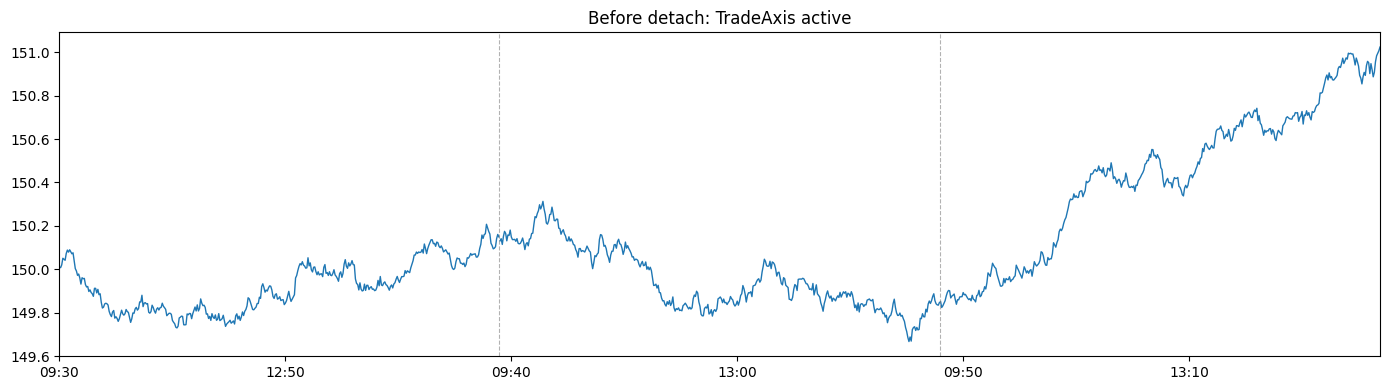

Lines remaining after detach: 0
Has _tradeaxis attr: False


In [8]:
fig, ax = plt.subplots(figsize=(14, 4))
chart = ta.wrap(ax, timestamps, prices, interaction=False)
ax.set_title("Before detach: TradeAxis active")
plt.tight_layout()
plt.show()

# Detach -- removes all TradeAxis lines, separators, formatter
chart.detach()

# Now the axes is completely clean
print(f"Lines remaining after detach: {len(ax.get_lines())}")
print(f"Has _tradeaxis attr: {hasattr(ax, '_tradeaxis')}")

## 8. Interactive Mode (try this locally!)

To experience the full interaction model, switch to an interactive backend and run the cell below.
This won't render inline -- it opens a native window with:

- **Left-drag** to pan
- **Right-drag up/down** to zoom in/out
- **Middle-click** to place a snap-to-data crosshair
- **Escape** to dismiss the crosshair

Backend options (uncomment the one that works on your system):

| Backend | Command | Requirement |
|---|---|---|
| Qt | `%matplotlib qt` | Requires PyQt5/PyQt6 (included in dev deps) |
| macOS native | `%matplotlib macosx` | macOS only, may require tkinter |
| Tk | `%matplotlib tk` | Requires tkinter (often missing in pyenv builds) |

In [9]:
# Uncomment ONE of the following lines and run this cell:
%matplotlib qt
# %matplotlib macosx    # macOS only (may require tkinter)
# %matplotlib tk        # cross-platform (needs tkinter)

fig, ax = plt.subplots(figsize=(14, 6))
chart = ta.wrap(ax, timestamps, prices, interaction=True)
ax.set_title("Interactive TradeAxis -- try pan/zoom/crosshair!")
ax.set_ylabel("Price ($)")
plt.show()

ImportError: Failed to import any of the following Qt binding modules: PyQt6, PySide6, PyQt5, PySide2

## 9. Crypto / Irregular Data

TradeAxis works with any timestamp series, not just equities. The auto heuristic adapts
to whatever cadence your data has.

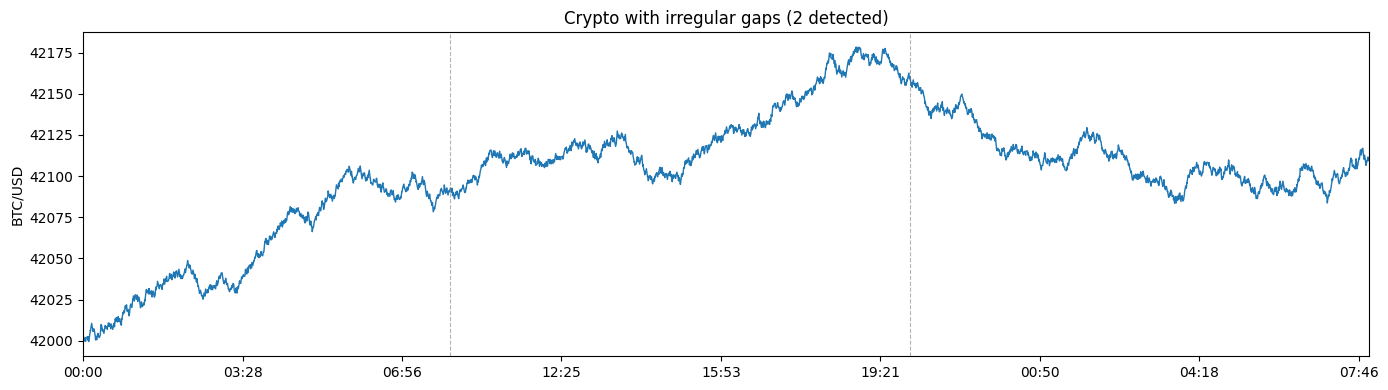

Total points: 20,160


In [16]:
# Simulate crypto data with irregular gaps (exchange maintenance windows)
np.random.seed(99)
base = np.datetime64("2026-02-01T00:00")
# 5-second data for 24 hours, with two 2-hour maintenance windows spliced out
chunk1 = np.arange(base, base + np.timedelta64(8, "h"), np.timedelta64(5, "s"))
chunk2 = np.arange(
    base + np.timedelta64(10, "h"),
    base + np.timedelta64(20, "h"),
    np.timedelta64(5, "s"),
)
chunk3 = np.arange(
    base + np.timedelta64(22, "h"),
    base + np.timedelta64(32, "h"),
    np.timedelta64(5, "s"),
)
crypto_ts = np.concatenate([chunk1, chunk2, chunk3])
crypto_prices = 42000 + np.cumsum(np.random.randn(len(crypto_ts)) * 0.5)

fig, ax = plt.subplots(figsize=(14, 4))
chart = ta.wrap(ax, crypto_ts, crypto_prices, interaction=False)
ax.set_title(f"Crypto with irregular gaps ({chart.mapping.gap_mask.sum()} detected)")
ax.set_ylabel("BTC/USD")
plt.tight_layout()
plt.show()

print(f"Total points: {len(crypto_ts):,}")

## 10. `plot_intraday()` Convenience

If you don't need a pre-existing figure, use the one-liner convenience function.

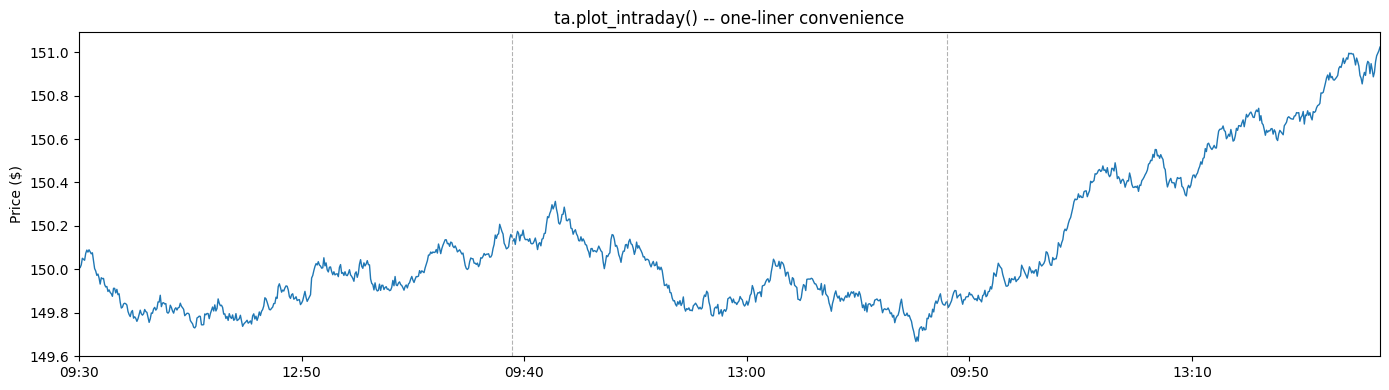

In [17]:
chart = ta.plot_intraday(timestamps, prices, figsize=(14, 4), interaction=False)
chart._ax.set_title("ta.plot_intraday() -- one-liner convenience")
chart._ax.set_ylabel("Price ($)")
plt.tight_layout()
plt.show()